In [1]:
!pip install pytorch_lightning

In [2]:
import sys
import os

def is_colab_env():
    return "google.colab" in sys.modules

def mount_google_drive(drive_dir="/content/drive/", repo_dir="MyDrive/repositories/deepfake-detection"):
    # mount google drive
    from google.colab import drive
    drive.mount(drive_dir)

    # change to correct working directory
    import os
    repo_dir = f"{drive_dir}{repo_dir}"
    os.chdir(repo_dir)
    print(os.listdir()) # verify content
    return repo_dir

def resolve_path(levels_deep=3):
    if is_colab_env():
        return mount_google_drive()
    else:
        # Get the directory of the current script
        current_dir = os.path.dirname(os.path.abspath('__file__'))

        # Construct the path to the parent directory
        for i in range(levels_deep):
            current_dir = os.path.dirname(current_dir)

        # Add the parent directory to sys.path
        sys.path.append(current_dir)
        print(sys.path)
        return current_dir

proj_dir = resolve_path(2)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
['src', '.git', 'playground', 'setup', 'README.md', 'environment.yml', 'environment-updated.yml', 'hf_wdf.sh', 'run_jupyter.sh', '.gitignore', 'freqnet_image.ipynb', 'config.py', 'reports', '__pycache__']


In [3]:
# import local config
import config

In [4]:
# from src.adapters.datasets.wilddeepfake import load_streaming_dataset
from datasets import load_dataset

In [10]:
import torch

In [5]:
from src.transforms.frequency import fft_real_imag

In [6]:
dataset = load_dataset("xingjunm/WildDeepfake", streaming=True, split="test")

Resolving data files:   0%|          | 0/963 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/157 [00:00<?, ?it/s]

In [7]:
from tqdm import tqdm

In [8]:
import numpy as np

real_fft_mean = None
fake_fft_mean = None
real_count = 0
fake_count = 0

pbar = tqdm(total=165662)

for d in dataset:
    img = d['png']
    fft_result = fft_real_imag(img)  # Returns a NumPy array
    fft_result = fft_result.detach().cpu().numpy()

    if "real" in d["__key__"]:
        real_count += 1
        if real_fft_mean is None:
            real_fft_mean = np.zeros_like(fft_result, dtype=np.float64)
        real_fft_mean += (fft_result - real_fft_mean) / real_count
    else:
        fake_count += 1
        if fake_fft_mean is None:
            fake_fft_mean = np.zeros_like(fft_result, dtype=np.float64)
        fake_fft_mean += (fft_result - fake_fft_mean) / fake_count

    pbar.update(1)


100%|█████████▉| 165654/165662 [31:56<00:00, 137.95it/s]

In [17]:
print("Real samples:", real_count)
print("Fake samples:", fake_count)

Real samples: 58659
Fake samples: 107003


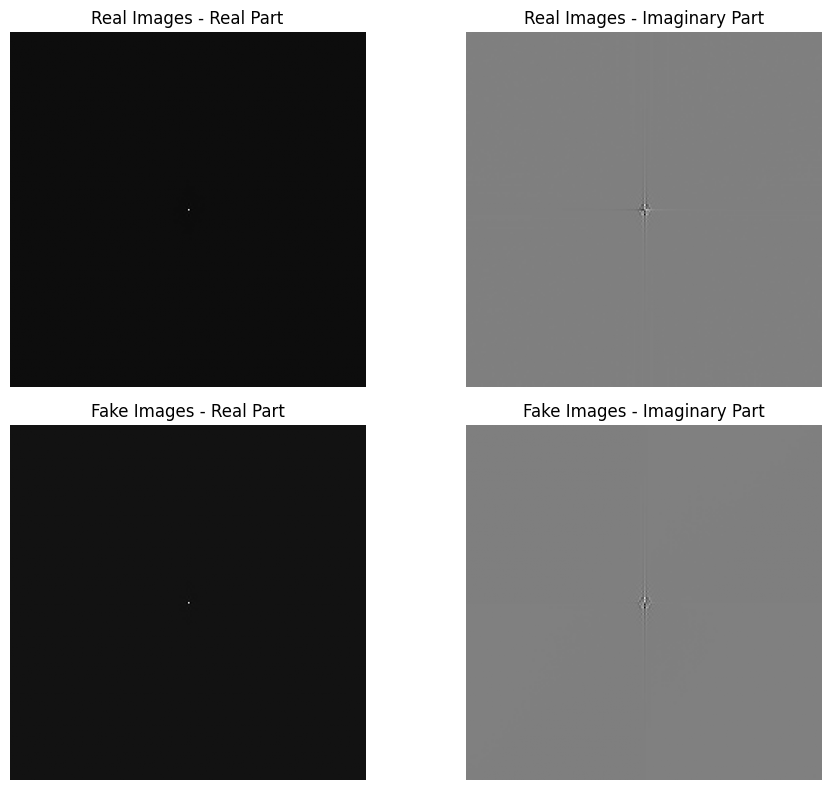

In [9]:
import matplotlib.pyplot as plt

# mean_real_fft and mean_fake_fft have shape (2, H, W)
mean_real_real = real_fft_mean[0]      # Real part for real images
mean_real_imag = real_fft_mean[1]      # Imaginary part for real images
mean_fake_real = fake_fft_mean[0]      # Real part for fake images
mean_fake_imag = fake_fft_mean[1]      # Imaginary part for fake images

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].imshow(mean_real_real, cmap='gray')
axs[0, 0].set_title('Real Images - Real Part')
axs[0, 1].imshow(mean_real_imag, cmap='gray')
axs[0, 1].set_title('Real Images - Imaginary Part')
axs[1, 0].imshow(mean_fake_real, cmap='gray')
axs[1, 0].set_title('Fake Images - Real Part')
axs[1, 1].imshow(mean_fake_imag, cmap='gray')
axs[1, 1].set_title('Fake Images - Imaginary Part')
for ax in axs.ravel():
    ax.axis('off')
plt.tight_layout()
plt.show()

In [23]:
magnitude_real = np.sqrt(real_fft_mean[0]**2 + real_fft_mean[1]**2)
log_magnitude_real = np.log1p(magnitude_real)  # Better dynamic range

magnitude_fake = np.sqrt(fake_fft_mean[0]**2 + fake_fft_mean[1]**2)
log_magnitude_fake = np.log1p(magnitude_fake)  # Better dynamic range

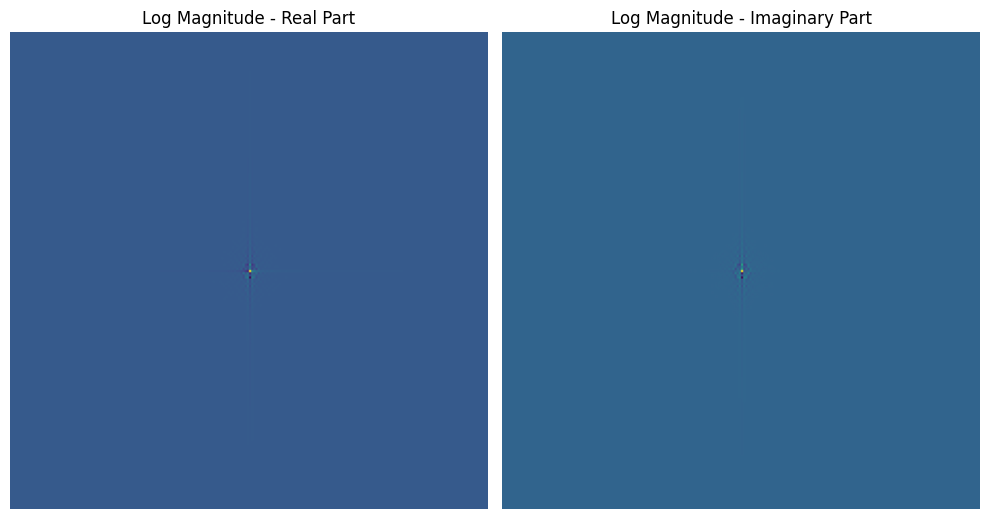

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
axs[0].imshow(log_magnitude_real)
axs[0].set_title('Log Magnitude - Real Part')
axs[1].imshow(log_magnitude_fake)
axs[1].set_title('Log Magnitude - Imaginary Part')
for ax in axs.ravel():
    ax.axis('off')
plt.tight_layout()
plt.show()

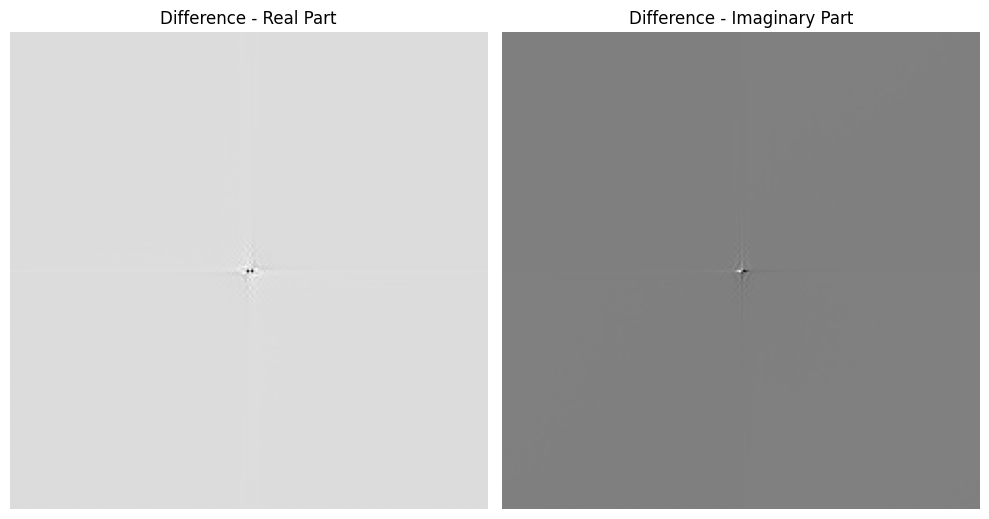

In [22]:
diff_real = fake_fft_mean[0] - real_fft_mean[0]
diff_imag = fake_fft_mean[1] - real_fft_mean[1]

fig, axs = plt.subplots(1, 2, figsize=(10, 8))
axs[0].imshow(diff_real, cmap='gray')
axs[0].set_title('Difference - Real Part')
axs[1].imshow(diff_imag, cmap='gray')
axs[1].set_title('Difference - Imaginary Part')
for ax in axs.ravel():
    ax.axis('off')
plt.tight_layout()
plt.show()

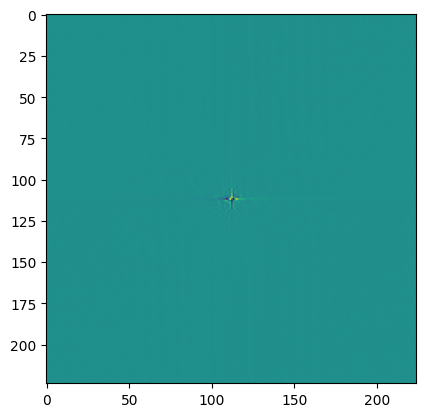

In [29]:
fft_result = None
for d in dataset:
  img = d['png']
  fft_result = fft_real_imag(img)  # Returns a NumPy array
  fft_result = fft_result.detach().cpu().numpy()
  break
plt.imshow(fft_result[1])
plt.show()